In [2]:
import pandas as pd

from glob import glob  
from natsort import natsorted, ns

import geopy
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import rasterio  
from rasterio.plot import show
from pyproj import Transformer
from rasterio.windows import Window
import rioxarray 

import imageio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# To display interactive plot
# %matplotlib notebook
# To display static plot below the code block
%matplotlib inline

In [17]:
address = "Royal Palace of Brussels"
#address = "Avenue de la Perspective 29 1150 Woluwe-Saint-Pierre"

In [18]:
def get_coordinates(address: str) -> float:
        """Function to get address coordinate
            plot it on a map"""

        geolocator = Nominatim(user_agent="3D_house_app")
        location = geolocator.geocode(address)
        location.latitude, location.longitude
        location_lat_long = [location.latitude, location.longitude]
        return location_lat_long
        
def plot_address(address):
    """plot the address on a map"""
    geolocator = Nominatim(user_agent="3D_house_app")
    location = geolocator.geocode(address)
    location.latitude, location.longitude
    location_lat_long = [location.latitude, location.longitude]
    location_map = folium.Map(location=location_lat_long, zoom_start=25)
    folium.Marker(location=location_lat_long, popup=location_lat_long).add_to(location_map)
    return location_map 
plot_address(address)

In [19]:
latitude,longitude = get_coordinates(address)
latitude,longitude

(50.8419916, 4.361987605344064)

In [20]:
def transform_address(x,y):
    # transform to Belgium 'EPSG:31370' coordinate
    transformer = Transformer.from_crs("EPSG:4326", crs_to = 'EPSG:31370' ,always_xy=True)
    lat, lon = transformer.transform(longitude, latitude)
    return lat,lon

In [21]:
xx,yy = transform_address(longitude, latitude)
xx,yy

(149523.55230758275, 170175.8129200684)

In [22]:
def get_tif(path):
    #Function to get all tif files and sort them
    tif_file =[]
    files = glob(path,recursive = True) 
    for file in files: 
        tif_file.append(file)
    tif_file = natsorted(tif_file, alg=ns.IGNORECASE)
    return tif_file

In [23]:
dsm_path = './Map_files/DSM/**/*.tif'
DSM_tif = get_tif(dsm_path)
DSM_tif[:3]

['./Map_files/DSM/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif',
 './Map_files/DSM/DHMVIIDSMRAS1m_k02/GeoTIFF/DHMVIIDSMRAS1m_k02.tif',
 './Map_files/DSM/DHMVIIDSMRAS1m_k03/GeoTIFF/DHMVIIDSMRAS1m_k03.tif']

In [24]:
dtm_path = './Map_files/DTM/**/*.tif'
DTM_tif = get_tif(dtm_path)
DTM_tif[:3]

['./Map_files/DTM/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif',
 './Map_files/DTM/DHMVIIDTMRAS1m_k02/GeoTIFF/DHMVIIDTMRAS1m_k02.tif',
 './Map_files/DTM/DHMVIIDTMRAS1m_k03/GeoTIFF/DHMVIIDTMRAS1m_k03.tif']

In [25]:
tif_bounds = []
for i in DSM_tif:
    src = rasterio.open(i)
    tif_bounds.append(src.bounds)

In [26]:
tif_bounds[:3]

[BoundingBox(left=145000.0, bottom=238000.0, right=162000.0, top=247000.0),
 BoundingBox(left=162000.0, bottom=238000.0, right=194000.0, top=250000.0),
 BoundingBox(left=194000.0, bottom=238000.0, right=206000.0, top=248000.0)]

In [27]:
found_DSM_path = []
found_DTM_path = []
for i,bound in enumerate(tif_bounds,1):
    if (xx >= bound[0] and xx <= bound[2]) & \
        (yy >= bound[1] and yy <= bound[3]):
        if i<=9:
            found_DSM_path.append('./Map_files/DSM/DHMVIIDSMRAS1m_k0'+ str(i) +'/GeoTIFF/DHMVIIDSMRAS1m_k0'+ str(i) + '.tif')
            found_DTM_path.append('./Map_files/DTM/DHMVIIDTMRAS1m_k0'+ str(i) +'/GeoTIFF/DHMVIIDTMRAS1m_k0'+ str(i) + '.tif')
            print('Tif location: ', 'DHMVIIDSMRAS1m_k0' + str(i) + '.tif')
        else:
            found_DSM_path.append('./Map_files/DSM/DHMVIIDSMRAS1m_k'+ str(i) +'/GeoTIFF/DHMVIIDSMRAS1m_k'+ str(i) + '.tif')
            found_DTM_path.append('./Map_files/DTM/DHMVIIDTMRAS1m_k'+ str(i) +'/GeoTIFF/DHMVIIDTMRAS1m_k'+ str(i) + '.tif')
            print('Tif location: ', 'DHMVIIDSMRAS1m_k' + str(i) + '.tif')
    else:None

Tif location:  DHMVIIDSMRAS1m_k17.tif


In [28]:
rast_dsm_df = rioxarray.open_rasterio(found_DSM_path[0],masked=True,chunks=True)

RasterioIOError: ./Map_files/DSM/DHMVIIDSMRAS1m_k17/GeoTIFF/DHMVIIDSMRAS1m_k17.tif: No such file or directory

In [17]:
rast_dtm_df = rioxarray.open_rasterio(found_DTM_path[0],masked=True,chunks=True)

In [18]:
n = 100
left,bottom = [(xx-n),(yy+n)],[(xx+n),(yy+n)]
right,top = [(xx+n),(yy-n)] ,[(xx-n),(yy-n)]
geometries = [ {'type': 'Polygon', 'coordinates': [[left,bottom, right,top,left]]}]

In [19]:
clipped_dsm = rast_dsm_df.rio.clip(geometries)

In [21]:
clipped_dtm = rast_dtm_df.rio.clip(geometries)

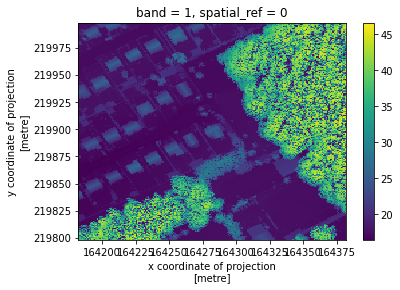

In [22]:
clipped_dsm.plot()